Running quantum error correction on Rigetti Ankaa-3...
AWS authentication successful using region: us-west-2
Account ID: 050451404824
Successfully connected to Rigetti Ankaa-3 device
Circuit to run on Rigetti Ankaa-3:
T   : │  0  │  1  │  2  │  3  │  4  │  5  │     6     │        7        │           8           │           9           │       10        │    11     │ 12  │ 13  │
                               ┌───┐ ┌───┐       ┌───┐             ┌───┐                   ┌───┐                                                                   
q7  : ───●─────────────────────┤ X ├─┤ Z ├───────┤ X ├─────────────┤ Z ├───────────────────┤ X ├───────────────────────────────────────────────────────────────────
         │                     └─┬─┘ └─┬─┘       └─┬─┘             └─┬─┘                   └─┬─┘                                                                   
         │               ┌───┐   │     │   ┌───┐   │         ┌───┐   │               ┌───┐   │                     ┌───┐      

C:\Users\aruna\AppData\Local\Temp\ipykernel_26196\3769738039.py:235: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(results['counts'].keys(), rotation=90)
C:\Users\aruna\AppData\Local\Temp\ipykernel_26196\3769738039.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(results['valid_shots'].keys(), rotation=90)


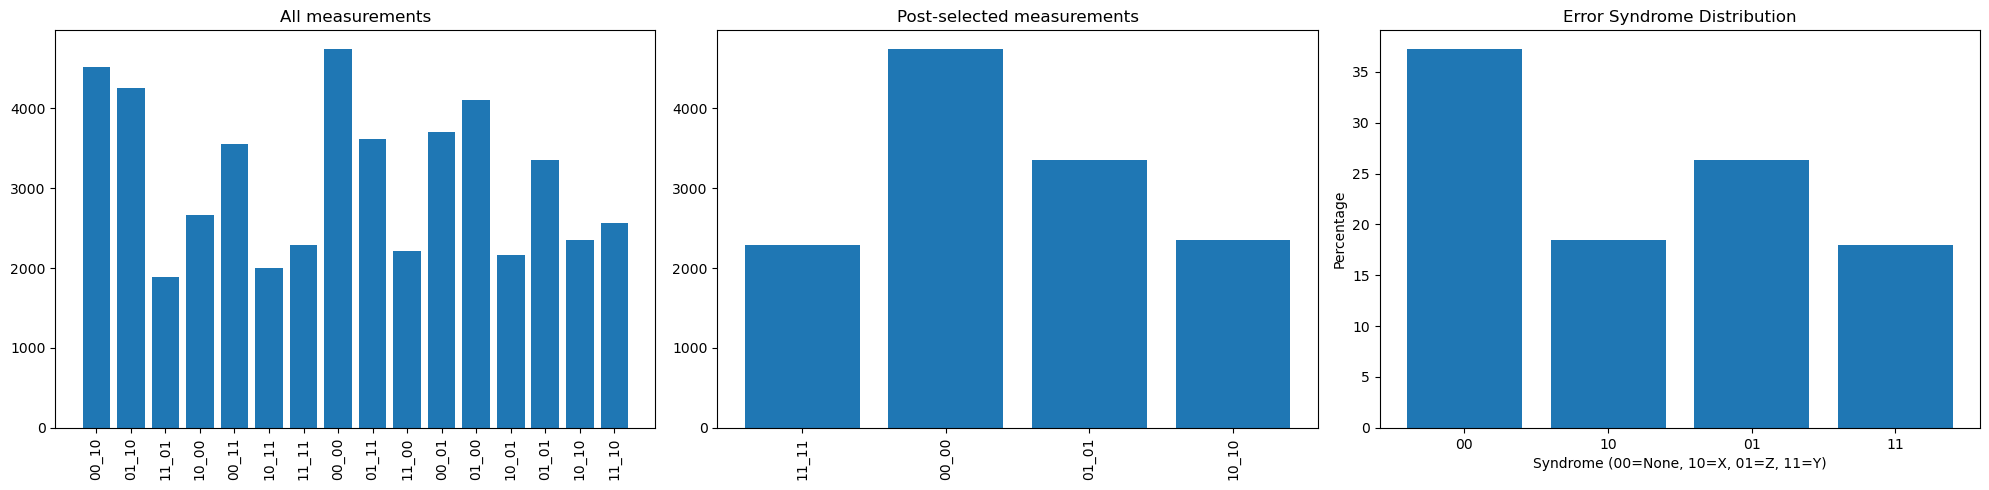


Error Analysis:
---------------
Error Types (counts): {'00': 4742, '10': 2355, '01': 3350, '11': 2291}
Error Percentages: {'00': '37.23%', '10': '18.49%', '01': '26.30%', '11': '17.99%'}

Circuit Analysis:
---------------
Total shots: 50000
Valid shots: 12738
Post-selection ratio: 0.25476


In [ ]:
"""
Quantum Error Correction Circuit Implementation for Rigetti Ankaa-3
Adapted for Braket SDK's measurement syntax
"""

import boto3
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from braket.aws import AwsDevice, AwsSession
from braket.circuits import Circuit

def setup_aws_session():
    
    try:
        # Create a custom boto3 session with the credentials
        boto_session = boto3.Session(
            aws_access_key_id='',           # Insert the actual access key
            aws_secret_access_key='',       # Insert with actual secret key
            aws_session_token='',           # Insert with session token
            region_name=''                  # Insert the region 
        )
        
        # Create a Braket AWS session using our boto3 session
        aws_session = AwsSession(boto_session=boto_session)
        print(f"AWS authentication successful using region: {boto_session.region_name}")
        
        # Get AWS account ID
        sts_client = boto_session.client('sts')
        account_id = sts_client.get_caller_identity()['Account']
        print(f"Account ID: {account_id}")
        
        return boto_session, aws_session
    
    except Exception as e:
        print(f"AWS Authentication Error: {str(e)}")
        raise

class RigettiQECCircuit:
    def __init__(self, aws_session):
        # Initialize QEC circuit for Rigetti Ankaa-3.
        try:
            self.device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3", aws_session=aws_session)
            print(f"Successfully connected to Rigetti Ankaa-3 device")
        except Exception as e:
            print(f"Error connecting to Rigetti device: {str(e)}")
            raise
        
    def create_circuit(self):
        
        # Create the quantum error correction circuit adapted for Rigetti architecture.
        
        # Create the circuit
        circuit = Circuit()
        
        # Initialise the qubits
        data_qubits = [7, 8, 9, 10]  # Adjusted for Rigetti hardware
        ancilla_round1 = [11, 12]    # First round ancillas
        ancilla_round2 = [13, 14]    # Second round ancillas 
        
        # Initialize data qubits
        circuit.h(data_qubits[3])  # Initialize in superposition
        
        # Entangle logical qubits
        circuit.cnot(data_qubits[0], data_qubits[2])
        circuit.cnot(data_qubits[1], data_qubits[2])
        circuit.cnot(data_qubits[3], data_qubits[2])
        circuit.cnot(data_qubits[3], data_qubits[1])
        circuit.cnot(data_qubits[3], data_qubits[0])
        
        # First round of syndrome extraction
        circuit.h(ancilla_round1[0])
        
        # Z syndrome (using CZ gates)
        for i in data_qubits:
            circuit.cz(ancilla_round1[0], i)
        circuit.h(ancilla_round1[0])
        
        # X syndrome
        circuit.h(ancilla_round1[1])
        for i in data_qubits:
            circuit.cnot(ancilla_round1[1], i)
        circuit.h(ancilla_round1[1])
        
        # Measure first round syndrome qubits
        circuit.measure(ancilla_round1[0])
        circuit.measure(ancilla_round1[1])
        
        # Second round of syndrome extraction with different ancilla qubits
        circuit.h(ancilla_round2[0])
        
        # Z syndrome (using CZ gates)
        for i in data_qubits:
            circuit.cz(ancilla_round2[0], i)
        circuit.h(ancilla_round2[0])
        
        # X syndrome
        circuit.h(ancilla_round2[1])
        for i in data_qubits:
            circuit.cnot(ancilla_round2[1], i)
        circuit.h(ancilla_round2[1])
        
        # Measure second round syndrome qubits
        circuit.measure(ancilla_round2[0])
        circuit.measure(ancilla_round2[1])
        
        return circuit
    
    def run_circuit(self, shots=100):
        
        # Run the circuit on Rigetti Ankaa-3.
        # Create circuit
        circuit = self.create_circuit()
        
        # Print the circuit
        print("Circuit to run on Rigetti Ankaa-3:")
        print(circuit)
        
        # Run the circuit on the quantum device
        print("\nSubmitting to Rigetti Ankaa-3...")
        try:
            task = self.device.run(circuit, shots=shots)
            
            # Get the task ARN (Amazon Resource Name)
            task_arn = task.id
            print(f"Task ARN: {task_arn}")
            
            # Wait for the task to complete
            print("Waiting for results...")
            result = task.result()
            
            # Process results
            counts = result.measurement_counts
            print("\nResults:")
            print(counts)
            
            # Post-process results
            return self._process_results(counts, shots)
            
        except Exception as e:
            print(f"Error running circuit: {str(e)}")
            return None
    
    def _process_results(self, counts, shots):
    
        # Process the results from the quantum hardware.
        
        
        # Convert to more readable format
        formatted_counts = {}
        for bitstring, count in counts.items():
            if len(bitstring) == 4:  
                # First round syndrome
                syndrome1 = bitstring[0:2]
                # Second round syndrome
                syndrome2 = bitstring[2:4]
                new_key = f"{syndrome1}_{syndrome2}"
                formatted_counts[new_key] = count
            else:
               
                formatted_counts[bitstring] = count
        
        # Post-select valid results
        valid_shots = {k: v for k, v in formatted_counts.items() 
                      if '_' in k and k.split('_')[0] == k.split('_')[1]}
        
        # Analyze error types
        error_types = {'00': 0, '10': 0, '01': 0, '11': 0}
        total_valid = sum(valid_shots.values()) if valid_shots else 0
        
        for bitstring, count in valid_shots.items():
            syndrome = bitstring.split('_')[0]  # Use the first round syndrome
            if syndrome in error_types:
                error_types[syndrome] += count
        
        # Calculate percentages
        error_percentages = {
            syndrome: (count/total_valid*100 if total_valid > 0 else 0.0)
            for syndrome, count in error_types.items()
        }
        
        return {
            'counts': formatted_counts,
            'valid_shots': valid_shots,
            'error_types': error_types,
            'error_percentages': error_percentages,
            'total_shots': shots,
            'valid_shot_count': total_valid,
            'post_selection_ratio': total_valid/shots if shots > 0 else 0
        }
    
    def visualize_results(self, results):
        
        # Create visualization of circuit results.
       
        if not results:
            print("No results to visualize.")
            return
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        
        # All measurements
        ax1.bar(results['counts'].keys(), results['counts'].values())
        ax1.set_title("All measurements")
        ax1.set_xticklabels(results['counts'].keys(), rotation=90)
        
        # Post-selected measurements
        if results['valid_shots']:
            ax2.bar(results['valid_shots'].keys(), results['valid_shots'].values())
            ax2.set_title("Post-selected measurements")
            ax2.set_xticklabels(results['valid_shots'].keys(), rotation=90)
        else:
            ax2.text(0.5, 0.5, "No valid post-selected measurements",
                   horizontalalignment='center', verticalalignment='center')
            ax2.set_title("Post-selected measurements")
        
        # Error distribution
        syndromes = list(results['error_types'].keys())
        percentages = [results['error_percentages'][s] for s in syndromes]
        ax3.bar(syndromes, percentages)
        ax3.set_title("Error Syndrome Distribution")
        ax3.set_ylabel("Percentage")
        ax3.set_xlabel("Syndrome (00=None, 10=X, 01=Z, 11=Y)")
        ax3.set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.savefig('qec_rigetti_results.png')  # Save to file
        plt.show()
        
        # Print analysis
        print("\nError Analysis:")
        print("---------------")
        print("Error Types (counts):", results['error_types'])
        print("Error Percentages:", {k: f"{v:.2f}%" 
                                   for k, v in results['error_percentages'].items()})
        print("\nCircuit Analysis:")
        print("---------------")
        print("Total shots:", results['total_shots'])
        print("Valid shots:", results['valid_shot_count'])
        print("Post-selection ratio:", results['post_selection_ratio'])

def main():
    """Main execution function."""
    print("Running quantum error correction on Rigetti Ankaa-3...")
    
    try:
        # Setup AWS session 
        boto_session, aws_session = setup_aws_session()
        
        # Create QEC circuit
        qec = RigettiQECCircuit(aws_session)
        
        # Run the shots 
        results = qec.run_circuit(shots=50000)
        
        if results:
            qec.visualize_results(results)
            
    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nPlease check your AWS credentials, region, and Braket service access.")

if __name__ == "__main__":
    main()